In [213]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

### Reading the data

In [214]:
#Read the first file
df1 = pd.read_csv('data_median.csv')
df1

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole
0,2L52.1,ADE,29.40,29.40,29.4,29.4,29.4,29.4,29.40,29.40,0
1,2L52.1,ADEsh,19.60,19.60,19.6,19.6,19.6,19.6,19.60,19.60,0
2,2L52.1,ADL,1.15,1.15,19.7,2.3,2.3,2.3,1.15,1.15,0
3,2L52.1,ASE,1.20,1.20,1.2,1.2,1.2,1.2,1.20,1.20,0
4,2L52.1,ASH,12.10,12.10,12.1,12.1,12.1,12.1,12.10,12.10,0
...,...,...,...,...,...,...,...,...,...,...,...
854318,zyx-1,mu_sph,23.60,23.60,23.6,23.6,23.6,23.6,23.60,23.60,0
854319,zyx-1,pm3_pm4_pm5,1.35,1.35,3.4,4.4,4.6,2.7,1.35,1.35,0
854320,zyx-1,pm6,6.50,6.50,6.5,6.5,6.5,6.5,6.50,6.50,0
854321,zyx-1,pm7,0.90,0.90,0.9,0.9,0.9,0.9,0.90,0.90,0


The first issue I see with the data, even though we use a median data, is the recurrence of the values for the different time bins. Indeed, I believe this is how the data has been pre-processed, and it therefore makes it difficult to make a real case-study related to the different time bins, as they will in majority all have the same values throughout the different time intervals.

We will therefore work on our clustering without taking into account these features at first.

In [215]:
#Read the second file for cell_types
df2 = pd.read_csv('annotation.csv')
df2

,cell_type,cell_status,centriole
0,ADE,non_proliferating,absent
1,ADEsh,non_proliferating,absent
2,ADF,non_proliferating,absent
3,ADF_AWB_terminal_cells_but_undifferentiated,non_proliferating,absent
4,ADL,non_proliferating,absent
...,...,...,...
137,URB_and_possibly_URA,non_proliferating,absent
138,URX,non_proliferating,absent
139,XXX,non_proliferating,absent
140,Y,non_proliferating,present


### Playing a little bit with the data

In [216]:
#Some centrioles have value 'ambiguous'
df1['centriole'].unique()

array(['0', 'ambiguous', '1'], dtype=object)

In [217]:
df1['centriole'].value_counts(normalize=True)

0            0.843766
1            0.134298
ambiguous    0.021935
Name: centriole, dtype: float64

In [218]:
df2['centriole'].unique()

array(['absent', 'present', 'ambiguous'], dtype=object)

In [219]:
#Get rid of the ambiguous values
ambig = ['ambiguous']
df1 = df1[~df1['centriole'].isin(ambig)]
df2 = df2[~df2['centriole'].isin(ambig)]

In [220]:
df1 #Now 835583 rows

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole
0,2L52.1,ADE,29.40,29.40,29.4,29.4,29.4,29.4,29.40,29.40,0
1,2L52.1,ADEsh,19.60,19.60,19.6,19.6,19.6,19.6,19.60,19.60,0
2,2L52.1,ADL,1.15,1.15,19.7,2.3,2.3,2.3,1.15,1.15,0
3,2L52.1,ASE,1.20,1.20,1.2,1.2,1.2,1.2,1.20,1.20,0
4,2L52.1,ASH,12.10,12.10,12.1,12.1,12.1,12.1,12.10,12.10,0
...,...,...,...,...,...,...,...,...,...,...,...
854318,zyx-1,mu_sph,23.60,23.60,23.6,23.6,23.6,23.6,23.60,23.60,0
854319,zyx-1,pm3_pm4_pm5,1.35,1.35,3.4,4.4,4.6,2.7,1.35,1.35,0
854320,zyx-1,pm6,6.50,6.50,6.5,6.5,6.5,6.5,6.50,6.50,0
854321,zyx-1,pm7,0.90,0.90,0.9,0.9,0.9,0.9,0.90,0.90,0


In [221]:
#Just getting an idea of how many have centriole=1
df1.loc[df1['centriole'].astype(float) == 1]

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole
22,2L52.1,Germline,0.40,0.4,0.4,0.4,0.40,0.40,0.40,0.40,1
24,2L52.1,Intestine,2.10,3.8,8.9,1.7,0.85,0.85,0.85,0.85,1
25,2L52.1,Intestine_middle_and_posterior,1.50,1.5,1.5,1.5,1.50,1.50,1.50,1.50,1
26,2L52.1,P_cell,1.50,1.5,1.5,1.5,1.50,1.50,1.50,1.50,1
31,2L52.1,Seam_cell,0.25,2.9,5.7,1.1,0.25,0.50,0.25,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...
854290,zyx-1,Intestine_middle_and_posterior,0.00,0.0,0.0,0.0,0.70,0.00,0.00,1.10,1
854291,zyx-1,M_cell,0.00,0.0,6.5,0.1,0.00,0.00,0.00,27.30,1
854296,zyx-1,P_cell,0.00,1.1,0.0,14.6,0.00,0.00,0.00,0.00,1
854306,zyx-1,Seam_cell,0.00,0.0,0.0,4.1,28.30,17.40,0.00,0.00,1


In [222]:
df2 #Now 139 rows

,cell_type,cell_status,centriole
0,ADE,non_proliferating,absent
1,ADEsh,non_proliferating,absent
2,ADF,non_proliferating,absent
3,ADF_AWB_terminal_cells_but_undifferentiated,non_proliferating,absent
4,ADL,non_proliferating,absent
...,...,...,...
137,URB_and_possibly_URA,non_proliferating,absent
138,URX,non_proliferating,absent
139,XXX,non_proliferating,absent
140,Y,non_proliferating,present


In [223]:
df1['gene'].value_counts()

tads-1        137
nuo-3         137
nduo-5        137
nduo-6        137
C02F5.12      137
             ... 
Y37E11AL.1      1
Y37E11AL.9      1
Y8A9A.2         1
F02D10.3        1
Y4C6B.4         1
Name: gene, Length: 17134, dtype: int64

In [224]:
df1['cell_type'].value_counts()

BWM_anterior         12066
BWM_posterior        12031
BWM_head_row_1       10988
Seam_cell            10958
Intestine            10918
                     ...  
AIZ                   2307
Excretory_pore_G1     2031
PVR                   1617
XXX                   1616
FLP                   1372
Name: cell_type, Length: 137, dtype: int64

In [225]:
#Remove the 'centriole' column from df2 as it has alraedy been processed for df1
keep_col = ['cell_type', 'cell_status']
df2 = df2[keep_col]
df2

,cell_type,cell_status
0,ADE,non_proliferating
1,ADEsh,non_proliferating
2,ADF,non_proliferating
3,ADF_AWB_terminal_cells_but_undifferentiated,non_proliferating
4,ADL,non_proliferating
...,...,...
137,URB_and_possibly_URA,non_proliferating
138,URX,non_proliferating
139,XXX,non_proliferating
140,Y,non_proliferating


In [226]:
#Relational algebra
data_use = pd.merge(df1, df2, on="cell_type")
data_use

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole,cell_status
0,2L52.1,ADE,29.4,29.4,29.4,29.4,29.4,29.4,29.4,29.4,0,non_proliferating
1,2RSSE.1,ADE,105.2,105.2,105.2,105.2,105.2,105.2,105.2,105.2,0,non_proliferating
2,AH9.3,ADE,37.8,37.8,37.8,37.8,37.8,37.8,37.8,37.8,0,non_proliferating
3,B0025.4,ADE,89.5,89.5,89.5,89.5,89.5,89.5,89.5,89.5,0,non_proliferating
4,B0035.1,ADE,133.5,133.5,133.5,133.5,133.5,133.5,133.5,133.5,0,non_proliferating
...,...,...,...,...,...,...,...,...,...,...,...,...
835578,ztf-7,Possibly_ant_arc_V,36.7,36.7,36.7,36.7,36.7,36.7,36.7,36.7,0,non_proliferating
835579,ztf-9,Possibly_ant_arc_V,8.6,8.6,8.6,8.6,8.6,8.6,8.6,8.6,0,non_proliferating
835580,zyg-11,Possibly_ant_arc_V,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5,0,non_proliferating
835581,zyg-12,Possibly_ant_arc_V,122.9,122.9,122.9,122.9,122.9,122.9,122.9,122.9,0,non_proliferating


For the moment, we will mainly focus on the cell_type for the clustering; and the information on the cell status, whether there was a proliferation or not.

### Idea that does not really take into consideration the time bins:

In [231]:
col = ['gene','cell_type','centriole','cell_status']
print(data_use[col].dtypes)

gene            object
cell_type       object
centriole      float64
cell_status     object
dtype: object


First, we see that the type for 'centriole' is object, let's make it a float in order to be able to play with it.

In [232]:
data_use['centriole'] = data_use['centriole'].astype(float)
print(data_use[col].dtypes)

gene            object
cell_type       object
centriole      float64
cell_status     object
dtype: object


In [233]:
data_use['centriole'].value_counts()

0.0    720849
1.0    114734
Name: centriole, dtype: int64

In [241]:
data_use[['cell_type', 'centriole']].value_counts()

cell_type          centriole
BWM_anterior       0.0          12066
BWM_posterior      0.0          12031
BWM_head_row_1     0.0          10988
Seam_cell          1.0          10958
Intestine          1.0          10918
                                ...  
AIZ                0.0           2307
Excretory_pore_G1  1.0           2031
PVR                0.0           1617
XXX                0.0           1616
FLP                0.0           1372
Length: 137, dtype: int64

In [270]:
first_idea_cols = ['cell_type', 'centriole']
dg = data_use[first_idea_cols]
dg.groupby(first_idea_cols)[first_idea_cols].count()
dg = dg.groupby(first_idea_cols).size().reset_index(name='count')
dg

,cell_type,centriole,count
0,ADE,0.0,4439
1,ADEsh,0.0,2741
2,ADF,0.0,5968
3,ADL,0.0,8916
4,AFD,0.0,7605
...,...,...,...
132,pm1_pm2,0.0,6954
133,pm3_pm4_pm5,0.0,10422
134,pm6,0.0,6542
135,pm7,0.0,7202


<AxesSubplot:xlabel='centriole', ylabel='count'>

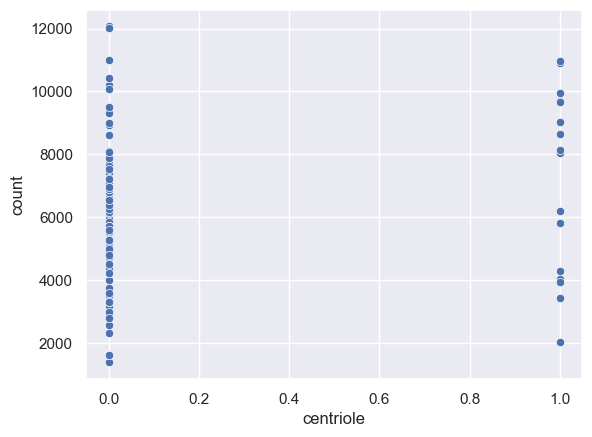

In [272]:
kmeans = KMeans(2)
keep = ['centriole', 'count']
d = dg[keep]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
#data_with_clusters
sns.scatterplot(x=data_with_clusters['centriole'],
               y=data_with_clusters['count'])

## Do not consider what's next

In [11]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x 

In [42]:
c1 = ['210_270', 'centriole']
c2 = ['270_330', 'centriole']
c3 = ['330_390', 'centriole']
c4 = ['390_450', 'centriole']
c5 = ['450_510', 'centriole']
c6 = ['510_580', 'centriole']
c7 = ['580_650', 'centriole']
c8 = ['gt_650', 'centriole']
cases = [c1, c2, c3, c4, c5, c6, c7, c8]

In [51]:
for c in cases:
    print(dg[c].head(5))
    print(" ")

         210_270  centriole
gene                       
2L52.1     497.3   0.005318
2RSSE.1   6223.4   0.007977
4R79.2     267.5   0.001773
6R55.2      21.2   0.003546
AC3.5        0.9   0.000000
 
         270_330  centriole
gene                       
2L52.1     496.5   0.005318
2RSSE.1   6221.8   0.007977
4R79.2     267.5   0.001773
6R55.2      21.2   0.003546
AC3.5        0.9   0.000000
 
         330_390  centriole
gene                       
2L52.1     531.5   0.005318
2RSSE.1   6266.9   0.007977
4R79.2     267.4   0.001773
6R55.2      21.2   0.003546
AC3.5        0.9   0.000000
 
         390_450  centriole
gene                       
2L52.1     499.7   0.005318
2RSSE.1   6183.9   0.007977
4R79.2     267.4   0.001773
6R55.2      21.2   0.003546
AC3.5        0.9   0.000000
 
         450_510  centriole
gene                       
2L52.1     464.6   0.005318
2RSSE.1   6165.0   0.007977
4R79.2     267.4   0.001773
6R55.2      21.2   0.003546
AC3.5        0.9   0.000000
 
         5

In [88]:
dg['Total time'] = dg.iloc[:,:8].sum(axis=1)
keep=['Total time', 'centriole']
dg = dg[keep]
dg

/var/folders/hd/zk5nyvz912q5x_8z8p_px_lh0000gn/T/ipykernel_60399/1413828940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['Total time'] = dg.iloc[:,:8].sum(axis=1)


,Total time,centriole
gene,,
2L52.1,3905.905318,0.005318
2RSSE.1,48346.507977,0.007977
4R79.2,2071.801773,0.001773
6R55.2,169.603546,0.003546
AC3.5,7.200000,0.000000
...,...,...
zyg-11,12900.808864,0.008864
zyg-12,47605.212409,0.012409
zyg-8,24287.808864,0.008864


<AxesSubplot:xlabel='centriole', ylabel='Total time'>

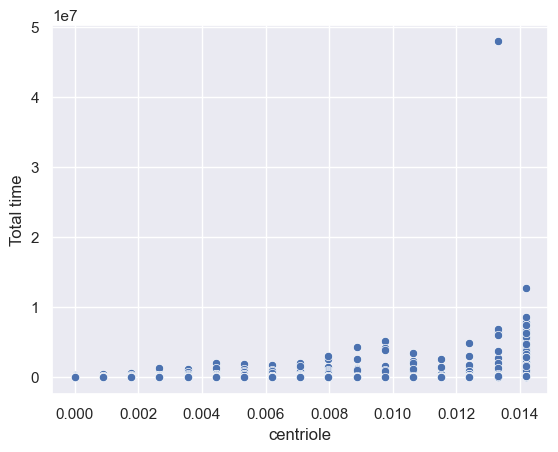

In [93]:
# General Case
kmeans = KMeans(2)
d = dg[keep]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
#data_with_clusters
sns.scatterplot(x=data_with_clusters['centriole'],
               y=data_with_clusters['Total time'])

In [94]:
dgg = dg[dg['centriole'] > 0.008]
#len(dgg.index)
#dgg.[0]

for i in range(len(dgg)):
    print(dgg.index[i])

AH9.3
B0001.3
B0001.4
B0001.5
B0001.8
B0019.2
B0024.10
B0024.11
B0025.4
B0035.1
B0035.15
B0035.3
B0041.5
B0041.8
B0205.1
B0205.6
B0205.8
B0205.9
B0207.6
B0228.1
B0228.6
B0238.11
B0250.5
B0261.1
B0261.8
B0272.3
B0280.9
B0281.5
B0285.3
B0285.4
B0286.1
B0303.3
B0303.4
B0303.7
B0334.3
B0334.4
B0334.5
B0336.13
B0336.3
B0336.5
B0336.7
B0361.2
B0361.3
B0361.6
B0361.9
B0365.9
B0393.3
B0393.5
B0395.3
B0416.5
B0454.9
B0464.6
B0464.9
B0491.1
B0491.5
B0491.6
B0491.7
B0495.5
B0495.7
B0495.8
B0495.9
B0507.2
B0511.12
B0511.13
B0511.2
B0511.6
B0511.7
B0546.4
B0564.2
B0564.7
BE0003N10.1
BE0003N10.3
C01A2.1
C01A2.4
C01B10.11
C01B10.8
C01B10.9
C01F1.1
C01F1.3
C01F1.6
C01F6.14
C01F6.9
C01G10.10
C01G10.8
C01G10.9
C01G5.5
C01G6.3
C01G6.4
C01G6.5
C01H6.8
C02B10.4
C02B10.5
C02B8.6
C02D5.2
C02D5.4
C02F12.8
C02F5.12
C02F5.13
C02F5.3
C03A3.1
C03B1.7
C03H12.1
C03H5.3
C04E6.11
C04E7.4
C04F5.8
C04F5.9
C04G6.4
C04H5.1
C05A9.2
C05C10.2
C05C10.3
C05C8.1
C05C8.2
C05C8.5
C05C8.7
C05D10.4
C05D11.1
C05D11.13
C05D11.5
C05D

<AxesSubplot:xlabel='centriole', ylabel='210_270'>

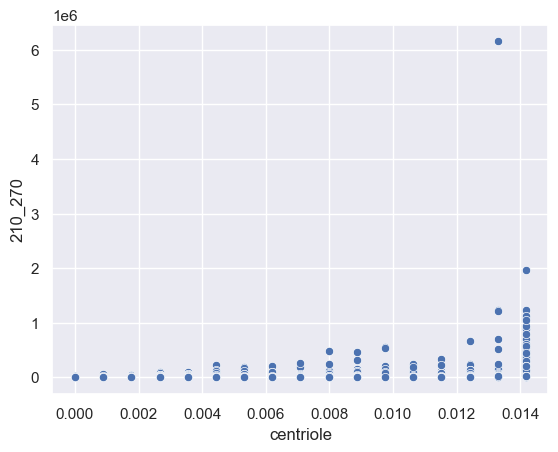

In [54]:
# Case 1
kmeans = KMeans(2)
d = dg[c1]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
#data_with_clusters
sns.scatterplot(x=data_with_clusters['centriole'],
               y=data_with_clusters[c1[0]])

In [79]:
dgg = dg[dg['centriole'] > 0.012]
#len(dgg.index)
#dgg.[0]

for i in range(len(dgg)):
    print(dgg.index[i])

B0001.5
B0024.11
B0025.4
B0035.1
B0041.8
B0205.8
B0228.6
B0238.11
B0261.1
B0261.8
B0272.3
B0285.3
B0285.4
B0303.3
B0303.4
B0303.7
B0334.3
B0334.4
B0334.5
B0336.13
B0336.3
B0336.5
B0336.7
B0361.3
B0416.5
B0491.1
B0491.5
B0491.6
B0491.7
B0495.5
B0495.7
B0495.8
B0495.9
B0511.12
B0511.13
B0511.6
B0546.4
B0564.7
C01A2.1
C01A2.4
C01B10.8
C01F1.1
C01F1.3
C01F6.9
C01G10.10
C01G10.8
C01G10.9
C01G6.5
C01H6.8
C02B10.4
C02D5.4
C02F5.12
C02F5.13
C02F5.3
C03A3.1
C03H12.1
C03H5.3
C04F5.8
C04G6.4
C05A9.2
C05C10.2
C05C8.1
C05C8.2
C05C8.7
C05D11.1
C05D11.13
C05D11.9
C05D2.10
C05D9.7
C06A5.3
C06A6.2
C06A8.3
C06B8.7
C06E7.4
C06G3.5
C06G3.6
C07A12.7
C07D10.5
C07H6.4
C08B11.9
C08F1.10
C09B7.2
C09E7.4
C11D2.4
C11D2.7
C11H1.7
C12D8.1
C13F10.1
C13F10.5
C13F10.6
C13F10.7
C14A4.3
C14B1.2
C14B1.8
C14B9.10
C14B9.2
C14B9.8
C14H10.2
C15C6.3
C15C7.5
C15C8.7
C16A3.4
C16A3.5
C16A3.6
C16C10.4
C16C10.8
C16C2.4
C16H3.3
C17E4.10
C17E4.20
C17E4.6
C17G1.5
C17H11.6
C18A3.3
C18B12.4
C18B12.6
C18C4.5
C18D11.3
C18D4.6
C18E3.9
C1

In [80]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,210_270,centriole,Clusters
gene,,,
hil-7,6148354.9,0.013296,1


<AxesSubplot:xlabel='centriole', ylabel='270_330'>

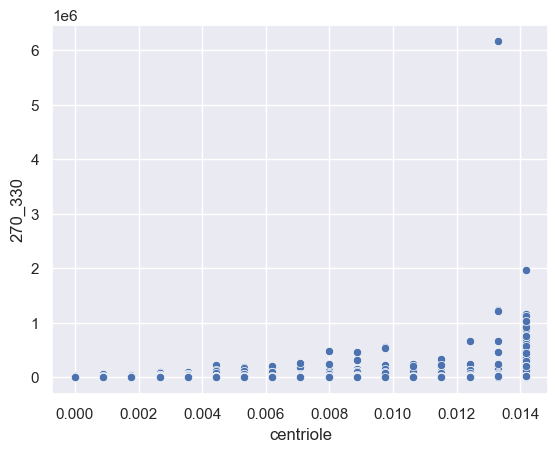

In [81]:
# Case 2
kmeans = KMeans(2)
d = dg[c2]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c2[0]])

In [106]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,270_330,centriole,Clusters
9164,42289.3,0,1
15096,34465.4,0,1
15105,58321.5,0,1
15109,33152.3,0,1
15111,37078.1,0,1
...,...,...,...
769228,34616.9,1,1
769229,33267.6,0,1
769239,37898.5,0,1
812672,131435.8,1,1


<AxesSubplot:xlabel='centriole', ylabel='330_390'>

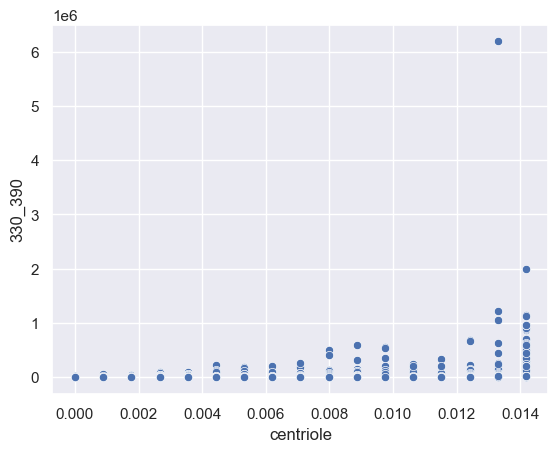

In [82]:
# Case 3
kmeans = KMeans(2)
d = dg[c3]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c3[0]])

In [108]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,330_390,centriole,Clusters
9164,42289.3,0,1
15096,34465.4,0,1
15105,58321.5,0,1
15111,37078.1,0,1
15122,41982.0,0,1
...,...,...,...
769228,34616.9,1,1
769238,38687.6,0,1
769239,68477.7,0,1
812672,154255.2,1,1


<AxesSubplot:xlabel='centriole', ylabel='390_450'>

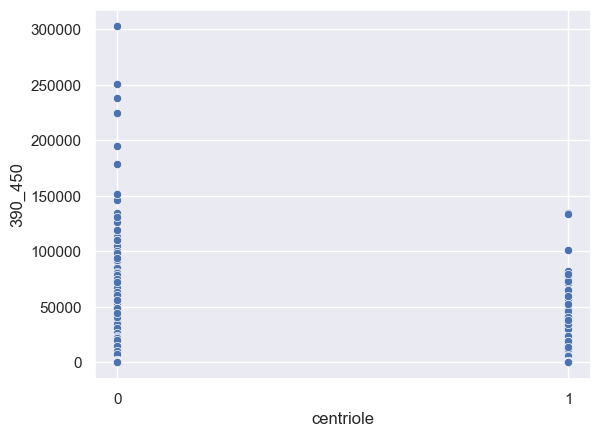

In [109]:
# Case 4
kmeans = KMeans(2)
d = data[c4]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c4[0]])

In [110]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,390_450,centriole,Clusters
9164,42289.3,0,1
15105,43307.8,0,1
15124,41919.8,0,1
19383,63440.8,0,1
19456,112452.6,0,1
...,...,...,...
769238,49107.3,0,1
769239,94267.8,0,1
810426,44214.5,0,1
812672,41016.8,1,1


<AxesSubplot:xlabel='centriole', ylabel='450_510'>

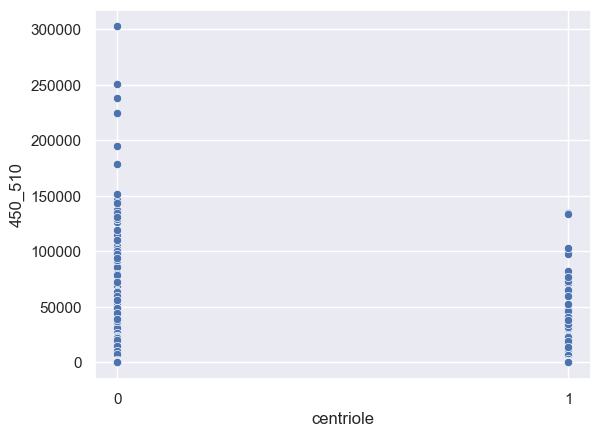

In [111]:
# Case 5
kmeans = KMeans(2)
d = data[c5]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c5[0]])

In [112]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,450_510,centriole,Clusters
9164,42289.3,0,1
15105,43307.8,0,1
15124,41919.8,0,1
19383,63440.8,0,1
19394,98049.2,1,1
...,...,...,...
810426,44214.5,0,1
811763,37616.4,0,1
811766,38842.8,0,1
812672,41016.8,1,1


<AxesSubplot:xlabel='centriole', ylabel='510_580'>

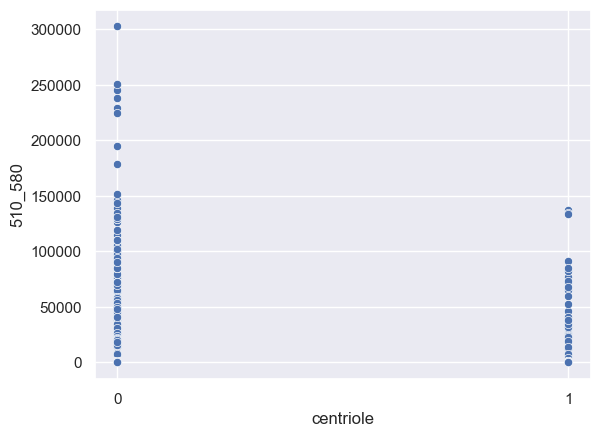

In [113]:
# Case 6
kmeans = KMeans(2)
d = data[c6]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c6[0]])

In [114]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,510_580,centriole,Clusters
9164,42289.3,0,1
13592,40402.0,0,1
15105,43307.8,0,1
19383,63440.8,0,1
19394,137189.9,1,1
...,...,...,...
811762,49648.7,0,1
811763,110483.5,0,1
811766,90492.1,0,1
812672,41016.8,1,1


<AxesSubplot:xlabel='centriole', ylabel='580_650'>

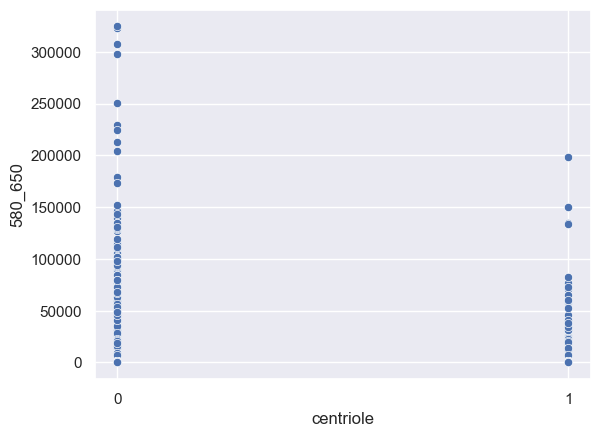

In [115]:
# Case 7
kmeans = KMeans(2)
d = data[c7]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c7[0]])

In [116]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,580_650,centriole,Clusters
13981,54853.4,0,1
19383,63440.8,0,1
19394,150415.6,1,1
19439,53574.1,0,1
19440,139088.1,0,1
...,...,...,...
810426,53546.3,0,1
811762,46156.6,0,1
811763,111900.7,0,1
811766,98339.7,0,1


<AxesSubplot:xlabel='centriole', ylabel='gt_650'>

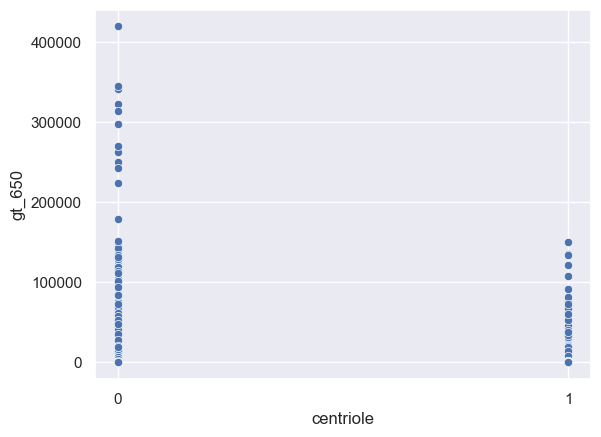

In [117]:
# Case 8
kmeans = KMeans(2)
d = data[c8]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters[c8[0]])

In [133]:
data_with_clusters.loc[data_with_clusters['centriole'].astype(float) == 1] # Clusters

,gt_650,centriole,Clusters
19394,150415.6,1,1
79262,134959.9,1,1
133711,75471.0,1,1
223129,57591.3,1,1
412524,133854.2,1,1
412548,71401.0,1,1
412596,64936.6,1,1
418418,92124.4,1,1
419953,69304.9,1,1
420251,107629.4,1,1


In [62]:
data_for_model = data.iloc[0:,0:8]
data_for_model = standardize(data_for_model)[0]
output = data.iloc[0:,9]
output = output.to_numpy()
bolean_selector = [output != "ambiguous"]
output = output[bolean_selector[0]]
print(len(bolean_selector[0]))
print(sum(bolean_selector[0].astype(int)))
bolean_selector_for_dataframe = pd.Series(bolean_selector[0])
data_for_model = data_for_model[bolean_selector_for_dataframe.values]
X = data_for_model.astype(float)
X = X.to_numpy()
y = output.astype(float)

835583
835583


In [64]:

kmeans = KMeans(2)
kmeans.fit(d1.astype(float))

KMeans(n_clusters=2)

In [65]:
identified_clusters = kmeans.fit_predict(d1)
identified_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

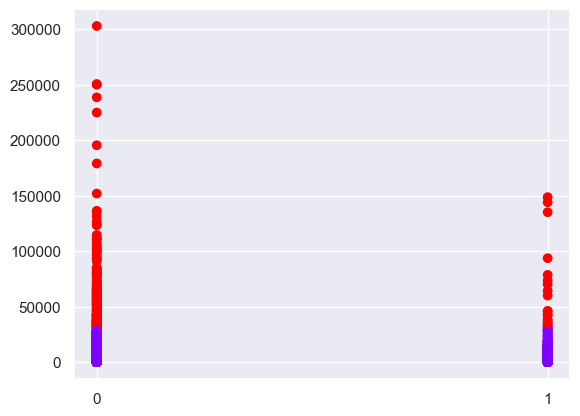

In [80]:
data_with_clusters = d1.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['centriole'],data_with_clusters['210_270'],c=data_with_clusters['Clusters'],cmap='rainbow')

<AxesSubplot:xlabel='centriole', ylabel='210_270'>

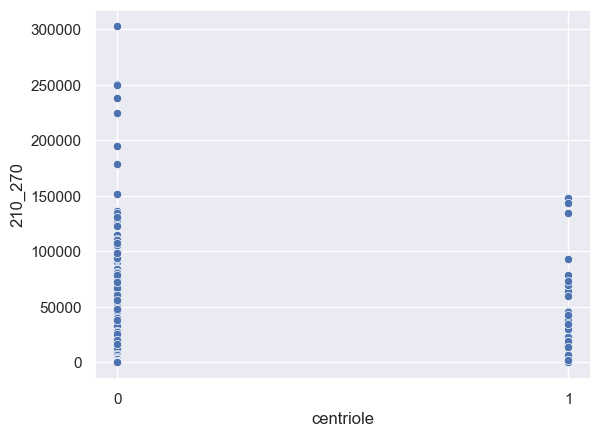

In [83]:
#data_with_clusters['330_390'],data_with_clusters['390_450'],data_with_clusters['450_510'],data_with_clusters['510_580'],data_with_clusters['580_650'],data_with_clusters['gt_650'],
sns.scatterplot(x=data_with_clusters['centriole'],
                y=data_with_clusters['210_270'])

In [126]:
data_with_clusters.loc[data_with_clusters['Clusters'] == 1]

,gt_650,centriole,Clusters
13592,73631.4,0,1
13981,54853.4,0,1
19383,63440.8,0,1
19394,150415.6,1,1
19439,53574.1,0,1
...,...,...,...
769226,59923.5,1,1
769239,94267.8,0,1
810426,53546.3,0,1
811763,111548.2,0,1
